In [1]:
from skimage.io import imread, imshow
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from sen1floods11_dataset import Sen1Floods11Dataset, Sen1Floods11DataModule

In [2]:
import os
ROOT = os.path.dirname(os.getcwd())
hand_labeled_data = os.path.join(ROOT, 'sen1floods11', 'hand_labeled.csv')
weak_labeled_data = os.path.join(ROOT, 'sen1floods11', 'weak_labeled.csv')
ROOT

'/home/genrev_kiel_hizon/SAR_flood_segmentation'

<Axes: xlabel='count', ylabel='Region'>

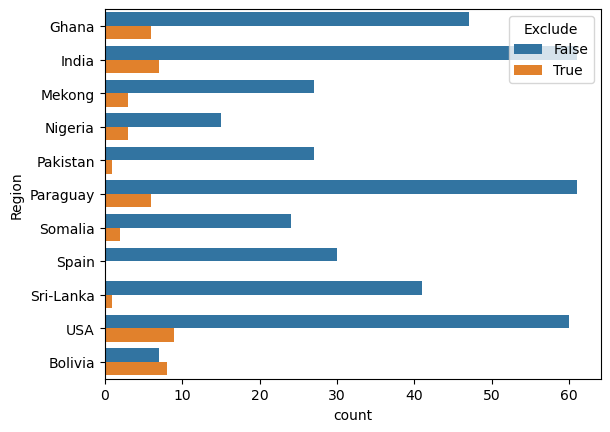

In [25]:
df = pd.read_csv(hand_labeled_data, index_col=0)
sns.countplot(data=df, y='Region', hue='Exclude')

In [9]:
df['Split'].unique()

array(['test', 'train', 'valid', 'hold out'], dtype=object)

In [3]:
def sample_img(dataset, idx=None):
    if not idx:
        idx = np.random.randint(len(dataset))
        
    _, ax = plt.subplots(1,4)
    
    ax[0].imshow(dataset['img'][idx][0], cmap='viridis',)
    ax[1].imshow(dataset['img'][idx][1], cmap='viridis',)
    ax[2].imshow(dataset['img'][idx][2], cmap='viridis',)
    ax[3].imshow(dataset['label'][idx], cmap='gray', vmin=-1, vmax=1)
    
    # plt.colorbar(ax[2].imshow(dataset['label'][idx], cmap='gray'), ax=ax[2])
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
        
    plt.show()
    
    return None

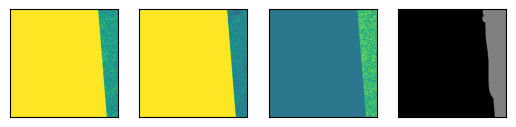

In [85]:
hand_labeled = Sen1Floods11DataModule(hand_labeled_data, 'HandLabeled', 'Combined', 8, debug=False, transforms=False)
hand_labeled.prepare_data()
train = next(iter(hand_labeled.train_dataloader()))
hold_out = hand_labeled.holdout_dataloader()
sample_img(train)

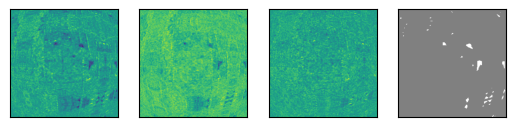

In [34]:
weakly_labeled = Sen1Floods11DataModule(weak_labeled_data, 'WeaklyLabeled', 8, debug=True, transforms=True)
weakly_labeled.prepare_data()
train = weakly_labeled.train_dataloader()
sample_img(next(iter(train)))

In [96]:
df = pd.read_csv(hand_labeled_data, index_col=0)
df.head()

,Region,Img_Id,Split
0,Ghana,313799,test
1,Ghana,1078550,test
2,Ghana,97059,test
3,Ghana,359826,test
4,Ghana,319168,test


In [153]:
def check_nans(row):
    TOTAL = 512**2
    img_path = os.path.join(ROOT, 'sen1floods11', 'flood_events', 'HandLabeled', 'S1Hand', f'{row.Region}_{row.Img_Id}_S1Hand.tif')
    label_path = os.path.join(ROOT, 'sen1floods11', 'flood_events', 'HandLabeled', 'LabelHand', f'{row.Region}_{row.Img_Id}_LabelHand.tif')
    img = imread(img_path)
    label = imread(label_path)
    
    row['img_0_nan'] = np.sum(np.isnan(img[0]))/TOTAL
    row['img_1_nan'] = np.sum(np.isnan(img[1]))/TOTAL
    row['LABEL_nan'] = np.sum(label==-1)/TOTAL
    
    return row

In [154]:
new_df = df.apply(check_nans, axis=1)
new_df.to_csv(os.path.join(ROOT, 'sen1floods11', 'hand_labeled_count_nan.csv'))

In [190]:
df_nans = new_df.loc[(new_df['img_0_nan']>0) |
          (new_df['img_1_nan']>0) |
           (new_df['LABEL_nan']>0)
          ]
df_nans.shape

(367, 6)

In [217]:
df_nans[df_nans['Split']=='train']

,Region,Img_Id,Split,img_0_nan,img_1_nan,LABEL_nan
0,Ghana,103272,train,0.000000,0.000000,0.010967
4,Ghana,154838,train,0.000000,0.000000,0.839375
5,Ghana,134751,train,0.856327,0.856327,0.835907
8,Ghana,144050,train,0.000000,0.000000,0.910160
10,Ghana,97516,train,0.000000,0.000000,0.284534
...,...,...,...,...,...,...
247,USA,1068362,train,0.000000,0.000000,0.000076
248,USA,806273,train,0.000000,0.000000,0.000050
249,USA,788696,train,0.000000,0.000000,0.000069
250,USA,348639,train,0.000000,0.000000,0.000099


In [224]:
NUM = 0.5
df_nans[(df_nans['img_0_nan']>NUM)|
       (df_nans['img_1_nan']>NUM)
       ]

,Region,Img_Id,Split,img_0_nan,img_1_nan,LABEL_nan
50,Paraguay,34417,test,1.000000,1.000000,0.809166
73,Sri-Lanka,450918,test,0.529911,0.529911,0.621864
5,Ghana,134751,train,0.856327,0.856327,0.835907
30,Ghana,135389,train,0.906067,0.906067,0.906067
40,India,979278,train,0.526783,0.526783,0.583935
148,Paraguay,224845,train,0.583500,0.583500,0.603577
237,USA,198411,train,0.665638,0.665638,0.678719
0,Bolivia,103757,hold out,0.612339,0.612339,0.664013


/home/genrev_kiel_hizon/SAR_flood_segmentation/sen1floods11/flood_events/HandLabeled/S1Hand/India_979278_S1Hand.tif


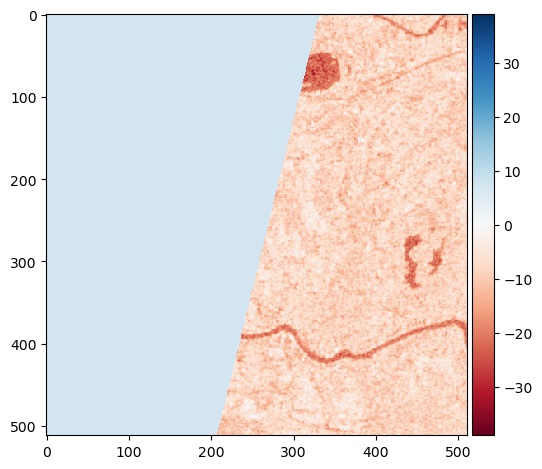

In [241]:
id = 979278
row = df_nans.loc[df_nans['Img_Id']==id]
img_path = os.path.join(ROOT, 'sen1floods11', 'flood_events', 'HandLabeled', 'S1Hand', f'{row.Region.values[0]}_{row.Img_Id.values[0]}_S1Hand.tif')
print(img_path)
img= imread(img_path)
img = np.where(np.isnan(img), np.nanmax(img)+1, img)
imshow(img[0])
# print(np.nanmin(img))

/home/genrev_kiel_hizon/SAR_flood_segmentation/sen1floods11/flood_events/HandLabeled/LabelHand/India_979278_LabelHand.tif


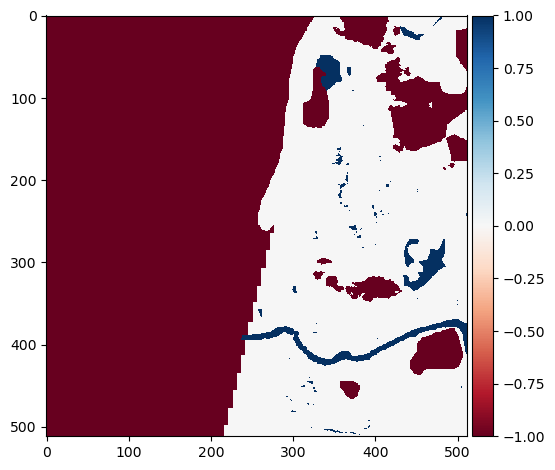

In [242]:
label_path = os.path.join(ROOT, 'sen1floods11', 'flood_events', 'HandLabeled', 'LabelHand', f'{row.Region.values[0]}_{row.Img_Id.values[0]}_LabelHand.tif')
print(label_path)
label= imread(label_path)
imshow(label)